### Deep Q Network for Cart Pole 
#### State = In put Layer ซึ่งหมายความว่าต้องมี 4 Node Input 
##### Qvalue แต่ล่ะ Action = Output ,  QLearning จะมาทำการปรับค่า QValue ตรงส่วน Output Layer เพื่อให้เกิดการ Train ค่าใน Neural Network ที่เกิดจากการปรับค่า QValue และทำการปรับค่าใน HIdden Layer ให้เหมาะสมอีกทีนั่นเอง

<img src="picture/Screenshot 2024-06-02 233113.png" alt="picture/Screenshot 2024-06-02 233113" width="600">
<img src="picture/Screenshot 2024-06-02 233129.png" alt="picture/Screenshot 2024-06-02 233129" width="600">
<!-- <img src="Screenshot 2024-06-02 233129.png" alt="Screenshot 2024-06-02 233129" width="600"> -->

##### -- เราต้องสร้างหน่วยความจำขึ้นมาก่อนสำหรับเก็บข้อมูล และทำการเก็บค่าที่เล่นไว้ในแต่ละเกม เพื่อนำข้อมูลมาทำการ Train ใน Neural Network
##### -- หลังจากเก็บชุดข้อมูลได้จำนวนนึง เราจะเอามาทำการ Train Output ของ Neural Network ด้วย Qlearning ที่เราเก็บไว้ก่อนหน้านี้
<img src="picture/deepq_1.png" alt="deepq_1" width="600">
<img src="picture/deepq_2.png" alt="deepq_2" width="600">

## Start Cartpole


In [163]:
import gym
import numpy as np
#-- tabulate ใช้สำหรับแสดง table Q learning ในี้ไม่ได้ใช้
from tabulate import tabulate
import gym_toytext
import matplotlib.pyplot as plt
import pandas as pd 
#-- Sequential Import เพิ่มส่งต่อ Class แม่สู๋ Class ลูก
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras import optimizers
#-- เก็บหน่วยความจำ ด้วย deque
from collections import deque 
import random 

## Log

In [164]:
import logging
import os 

# Define the log folder and file name
log_folder = 'logs'
log_file = 'batch.log'

# Create the log folder if it doesn't exist
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Define the full path to the log file
log_path = os.path.join(log_folder, log_file)

# Create a logger with the name of the current module
logger = logging.getLogger(__name__)

# Specify the file handler to output logs to a file named 'logs.log', in write mode ('w')
file_handler = logging.FileHandler(log_path, mode='w')  # 'w' stands for write

# Set the logging level for the file handler
file_handler.setLevel(logging.INFO)  # Set to the desired level (e.g., WARNING)

# Define the format of the log messages
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Clear existing handlers (if any) and add the file handler to the logger , avoid duplicate logs
logger.handlers = []  

# connect to log file using logger.addHandler(file_handler)
logger.addHandler(file_handler)

# Example of logging a WARNING message
logger.warning("-------- Start --------")


### DeepQ ต้องมีอะไรบ้าง ดังนี้
1. Input Layer : 4 ตัว ตามที่ Feature ของ Cartpole มี 
2. HIdden Layer เราจะมีไว้ 24 ตัว 2 ชั้น
3. Output : 2 ตัว Left, Right

In [165]:
#-- Inheritate from Sequential Class
#-- สร้าง Class ที่สืบทอดมาจาก Sequential
class NeuralNetwork(Sequential):
    #-- สร้าง Constructor พวก self, ค่าที่ต้องการให้มี
    #-- number of observation and action 
    def __init__(self, observation_space, action_space, learning_rate):
        #-- Constructor , we will set 2 hidden layer and 24 node for each 
        #-- super().__init__() : USe for build DeepLearning
        super().__init__()
        #-- add input and first hidden layer
        #-- HIdden 24 ตัว ใช้ relu ในการแปลงค่า , observation_space = feature of state 4 ตัว 
        self.add(Dense(24, input_shape=(observation_space,), activation = "relu"))
        #-- HIdden ชั้น 2 
        self.add(Dense(24,activation = "relu"))
        #-- output ถ้าอยากให้ระบุเป็น Label หมา แมว ไก้ ใช้ softmax , แต่เราอยากได้ค่าที่เป็ฯตัวเลข เลบใช้ linear 
        #-- Out put = action_space : 2 ตัว 
        self.add(Dense(action_space,activation="linear"))
        #-- ค่า Loss ใช้ Mse , Optimizer ใช้ Adam ในการลดรูป 
        self.compile(loss='mse',optimizer = optimizers.Adam(learning_rate=learning_rate))

    #-- State = X , target_output = Y (X data , Y Label)
    def train(self,state,target_output):
        self.fit(state, target_output, epochs =1, verbose= 0)

    #-- Predict ค่า X เพื่อหาค่า Y Label ที่ควรเป็น
    def predict_expected_reward_for_each_action(self,state):
        return self.predict(state)

In [176]:
class Agent():
    def __init__(self, epsilon_initial=0.5):
        #-- 1 million data store max
        #-- deque เป็นตัวเก็บหน่วยคววามจำ
        self.memory = deque(maxlen = 10000000)
        #-- มีการ Train เมื่อมีค่าในหน่วยความจำครบ 20 ข้อมูล ใช้ batch size
        self.batch_size = 20

        self.learning_rate = 0.001
        #-- discount_factor คือค่าถ่วงจำเพาะของสิ่งที่เป็นนาคต เช่น ปีปัจจุบัน กับ ปีข้างหน้า จะมีค่าไม่เท่ากัน
        self.discount_factor = 0.95
        self.epsilon = epsilon_initial
        #-- decay_factor for discount eplsilon 
        self.decay_factor = 0.99
        #-- for append the data inside the function of class , store the data (ทำเพื่อเอา data มาดูว่าเก็บอะไรมาบ้าง เหมือนเป็นตัวแปรตัวแปรนึง)
        self.reward_for_each_episode = []
        self.batch_length_store = []
        self.batch_store = []
        self.state_store = []
        self.state_next_store = []
        self.action_store = []
        self.reward_store = []
        self.qupdate_store =[]
        self.qvalue_before_adj_store = []
        self.qvalue_after_adj_store = []
        self.terminal_store = [] 
        self.neural_store = []
        self.epsilon_store = []
        self.q_values_train_store = 0
        self.run_count = 0
        self.reward_pergame_store = []
        #-- Neural Network
        self.neural_network = NeuralNetwork(4,2,self.learning_rate)


    def play(self, env, number_of_episode=10, isRender = False):
    # def play(self, env, number_of_episode=3000):
        for i_episode in range(number_of_episode):
            if(self.epsilon < 0.1):
                    print("Epsilon is Lower than Value")
                    print("Last Episode Run :", i_episode)
                    break
            print("Episode {} of {} ".format(i_episode + 1, number_of_episode))

            #-- state has 4 thing observation
            state, info = env.reset()
            #-- 1 : 1 pole(1ไม้) , 4 : 4ค่า ตำแหน่งรถเข็น , ความเร็วรถเข็น, องศาของเสา, ความเร็วเขิงมุม
            #-- state : 1x4 array state ใน Cartpole มี 4 อย่าง 
            state = np.reshape(state,[1,4])

            # self.epsilon *= self.decay_factor

            total_reward = 0
            end_game = False
            truncated = False
            
            while not (end_game or truncated):
                if isRender:
                    env.render()
                if self.__with_probability(self.epsilon):
                    #-- สุ่มการกระทำ
                    action = self.__getActionByRandomly(env)
                else:
                    #-- เลือก Action ที่ดีที่สุดจากการ Predict Value 
                    action = self.__getActionWithHighestExpectedReward(state)
                
                #-- Must have both end_game and truncated for end the loop 
                new_state, reward, end_game, truncated ,info = env.step(action)
                new_state = np.reshape(new_state, [1,4])
                if end_game or truncated:
                    reward = -200
                    self.run_count += 1
                else: 
                    total_reward += reward       
                self.reward_pergame_store.append([i_episode,reward])
                #-- เก็บข้อมูลในหน่วยความจำ

                self.remember(state,action,reward,new_state,end_game or truncated)
                state = new_state
                self.experience_replay()
            self.reward_for_each_episode.append(total_reward)
            

            # print(tabulate(self.q_table[0][0][0], showindex='always', headers=["State", "Action 0 (Forward 1 step)", 'Action 1 (Back to 0)']))

        # return self.q_table
            
            #---- print Result 
            # print("value of epsilon", self.epsilon)
            # print(tabulate(self.q_table, showindex='always'))
            # print(tabulate(self.q_table, showindex='always', headers=["State", "Action 0 (Forward 1 step)", 'Action 1 (Back to 0)']))
            #-- Stop exploration if epsilon is too small
            # if self.epsilon < 0.1:
            #     break
            #----

    #-- เช็คว่าค่าที่ random < epsilon ที่ตั้งไว้ไหม ถ้าน้อยกว่า ให้ทำการสุ่ม Action แทน
    def __with_probability(self, probability):
        return np.random.random() < probability

    #-- สุ่มการเดิน
    def __getActionByRandomly(self, env):
        return env.action_space.sample()

    #-- เลือกตำแหน่งของค่าที่เป็น Highest Reward เช่น เลือก action เดินไปทางขวา เพราะมีค่า Reward สูงสุด
    def __getActionWithHighestExpectedReward(self, state):
        # return np.argmax(self.q_table[state, :])
        return np.argmax(self.neural_network.predict_expected_reward_for_each_action(state)[0])

    #-- เก็บค่าที่เป็น highest reward เก็บค่าสูงสุดไว้
    def __getExpectedReward(self, state):
        # return np.max(self.q_table[state, :])
        return np.max(self.neural_network.predict_expected_reward_for_each_action(state)[0])

    #-- ให้มันจดจำ : Function เก็บหน่วยความจำ เก็บทั้ง 5 ค่า state, action, reward, next_state, done ตามตาราง
    def remember(self, state, action, reward, next_state, done):
        #-- ใช้ append ในการเก็บข้อมูล
        self.memory.append((state, action, reward, next_state, done))

    #-- Function สำหรับดคงข้อมูลจากหน่วยความจำ ในการ Train 
    def experience_replay(self):
        #-- if data is less than 20 do nothing 
        #-- เช็คว่ามีข้อมูลในหน่วยความจำมีค่า ครบ 20 ตัวรึยัง
        if len(self.memory) < self.batch_size:
            return 
        #-- Get Random Sample
        #-- สุ่มข้อมูลมา 20 ตัว จากที่กำหนดไว้
        batch = random.sample(self.memory, self.batch_size)

        #-- เก็บ log ของ batch
        batch_length = len(batch)
        self.batch_length_store.append(batch_length)
        self.batch_store.append(batch)
        logger.warning(f"length of batch is : {batch_length}")
        #-- 
        
        for state, action, reward, state_next, terminal in batch:
            #-- Discover Data Using Append
            self.state_store.append(state)
            self.state_next_store.append(state_next)
            self.action_store.append(action)
            self.reward_store.append(reward)
            self.terminal_store.append(terminal)
            #--
            q_update = reward
            #-- ถ้ายังไม่จบเกม
            if not terminal:
                #-- ค่า Q Value ที่ได้จาก วมการ Q learning
                q_update = reward + self.discount_factor * self.__getExpectedReward(state_next)
                self.qupdate_store.append(q_update)
            #-- q value จาก neural network
            q_values = self.neural_network.predict_expected_reward_for_each_action(state)
            q_values_copy = q_values.copy()
            self.qvalue_before_adj_store.append(q_values_copy)
            #-- ปรับค่า q value ให้เหมือนกับ q learning ที่คำนวณได้ออกมา
            q_values[0][action] = q_update
            #-- เอา q value ที่มีแก้ไขค่าให้สอดคล้องกับ สมการ q learning ของเรา และเอา q value ของเรามาทำการ train neural network ของเรา
            self.neural_network.train(state,q_values)
            self.qvalue_after_adj_store.append(q_values)
            # self.neural_store.append(neural_get)
            self.q_values_train_store = q_values

        #--
        self.epsilon *= self.decay_factor
        self.epsilon_store.append(self.epsilon)


    #-- ไม่ได้ใช้แล้ว สำหรับ DQN
    #-- check ว่าค่า ที่มีของ qtable ณ state นั้นๆ เป็น 0 หรือไม่
    # def __qTableIsEmpty(self, state):
    #     # return np.sum(self.q_table[state, :]) == 0
    #     return np.sum(self.q_table[state]) == 0

    #-- ดูว่า value ที่ได้อยู่ในช่วงไหนของกรอบที่เรา set ไว้ 10 ช่วง 
    #-- ไม่ได้ใช้แล้ว สำหรับ DQN
    # def __to_bin(self, value, bins):
    #     x = value 
    #     bins = bins
    #     return np.digitize(x, bins)


Episode 1 of 4 
1/1 [==============================] - ETA: 0s

c:\Users\HP\anaconda3\envs\ecoding\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1/1 [==============================] - 0s 14ms/step
Episode 2 of 4 
1/1 [==============================] - 0s 26ms/step
Episode 3 of 4 
1/1 [==============================] - 0s 27ms/step
Episode 4 of 4 
1/1 [==============================] - 0s 15ms/step


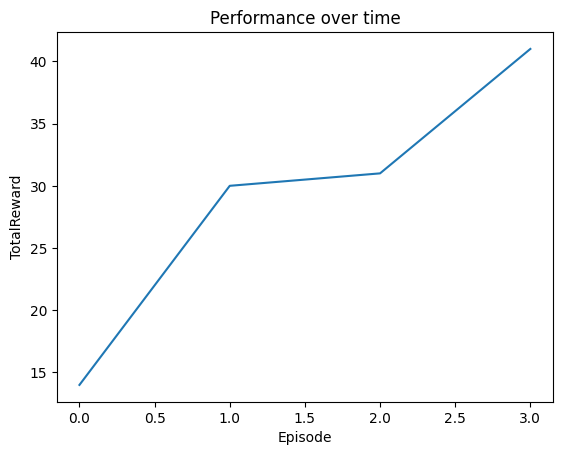

In [177]:
#--  gym.make('CartPole-v1',render_mode="human") : This make process very slow
# env = gym.make('CartPole-v1',render_mode="human")
env = gym.make('CartPole-v1')
agent = Agent()
qtable_store = agent.play(env, 4
                          , False)
# agent.play(env)
plt.title("Performance over time")
plt.ylabel('TotalReward')
plt.xlabel('Episode')
plt.plot(agent.reward_for_each_episode)
plt.show()

In [178]:
display("Memory Lenght :",len(agent.memory))

'Memory Lenght :'

120

In [179]:
display("Reward Store each Loop :",agent.reward_pergame_store[0:5])
display("Total Reward each Loop :",agent.reward_for_each_episode)

'Reward Store each Loop :'

[[0, 1.0], [0, 1.0], [0, 1.0], [0, 1.0], [0, 1.0]]

'Total Reward each Loop :'

[14.0, 30.0, 31.0, 41.0]

### Check Variable Data 

In [180]:
# agent.batch_length_store 
# agent.batch_store 
# agent.state_store
# agent.state_next_store 
# agent.action_store
# agent.reward_store
# agent.terminal_store 
# agent.neural_store 
# agent.epsilon_store
# agent.qupdate_store
# agent.qvalue_before_adj_store
# agent.qvalue_after_adj_store
# agent.q_values_train_store

In [181]:
display("Run Time Count :" ,agent.run_count)
display("Experience Replay Time Count :" ,len(agent.batch_length_store))
display("Number of Batch Size :" ,len(agent.batch_store[0]))
display("State on Selected Batch :", agent.state_store[5])
display("Next State on Selected Batch :",agent.state_next_store[5])
display("Action Value", agent.action_store[5])

'Run Time Count :'

4

'Experience Replay Time Count :'

101

'Number of Batch Size :'

20

'State on Selected Batch :'

array([[-0.12830704, -1.537336  ,  0.20519617,  2.3600159 ]],
      dtype=float32)

'Next State on Selected Batch :'

array([[-0.15905377, -1.7336154 ,  0.2523965 ,  2.7081635 ]],
      dtype=float32)

'Action Value'

0

In [182]:
display("Neural Train Time Count :", len(agent.reward_store))
display("Terminal Value :", agent.terminal_store[0:10])
display("Reward Value :", agent.reward_store[0:10])


'Neural Train Time Count :'

2020

'Terminal Value :'

[False, False, False, False, False, True, False, False, False, False]

'Reward Value :'

[1.0, 1.0, 1.0, 1.0, 1.0, -200, 1.0, 1.0, 1.0, 1.0]

In [183]:
display("Epsilpon Value :",agent.epsilon_store[0:5])

'Epsilpon Value :'

[0.495, 0.49005, 0.48514949999999996, 0.480298005, 0.47549502494999996]

In [184]:
display("Q Update :", agent.qupdate_store[0:5])
display("Q Value Before Update :", agent.qvalue_before_adj_store[0:5])
display("Q Value After Update :",agent.qvalue_after_adj_store[0:5])
display("Q Value Update :",agent.q_values_train_store[0])

'Q Update :'

[1.0420110566541552,
 1.0603415433317422,
 1.3527553111314774,
 1.3237208887934684,
 1.114955697208643]

'Q Value Before Update :'

[array([[ 1.042011  , -0.01525986]], dtype=float32),
 array([[0.01032026, 1.0603416 ]], dtype=float32),
 array([[ 1.3527553 , -0.14066963]], dtype=float32),
 array([[ 1.3237209 , -0.12334413]], dtype=float32),
 array([[ 1.1149557 , -0.02887962]], dtype=float32)]

'Q Value After Update :'

[array([[ 1.042011  , -0.01525986]], dtype=float32),
 array([[0.01032026, 1.0603416 ]], dtype=float32),
 array([[ 1.3527553 , -0.14066963]], dtype=float32),
 array([[ 1.3237209 , -0.12334413]], dtype=float32),
 array([[ 1.1149557 , -0.02887962]], dtype=float32)]

'Q Value Update :'

array([3.733723 , 1.6533029], dtype=float32)

In [185]:
#-- Check Reward which data is -200
count_200 = agent.reward_store.count(-200)
display("All value of reward :",(agent.reward_store[0:5]))
display("Total Train Data :", len(agent.reward_store))
display("Reward -200 count number is :",count_200)

'All value of reward :'

[1.0, 1.0, 1.0, 1.0, 1.0]

'Total Train Data :'

2020

'Reward -200 count number is :'

55